In [23]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import SyntheticDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [24]:
from dataset import SyntheticDataset, SyntheticDatasetType
dataset_type = SyntheticDatasetType.SNR20
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')
dataset = SyntheticDataset(config.Synthetic_PATH, type=dataset_type ,transform=None)

In [25]:
def preprocessing(X:np.ndarray):
        '''
            Preprocessing the dataset for removing high-frequency noise. 
            This preprocessing consists of three steps:
                1. Median filter in the spatial domain.
                2. Moving average filter in the spectral domain. (No!)
                3. Normalization of the data.

            Parameters
            ----------
                X : np.ndarray, shape (nRow, nCol, nBand)
                    HSI Cube.
        '''
        from skimage.filters import median
        from utils import moving_average

        # X = median(X, footprint=np.ones((3,3,1)))
        # X = moving_average(X.reshape(-1, X.shape[-1]), 5, padding_size=4).reshape(X.shape[0], X.shape[1], -1)
        return X

X_filtered = preprocessing(dataset.X.reshape(dataset.n_row, dataset.n_col, -1))
dataset.X = torch.tensor(X_filtered.reshape(-1, X_filtered.shape[-1])).float()

/tmp/ipykernel_14190/1692831112.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset.X = torch.tensor(X_filtered.reshape(-1, X_filtered.shape[-1])).float()


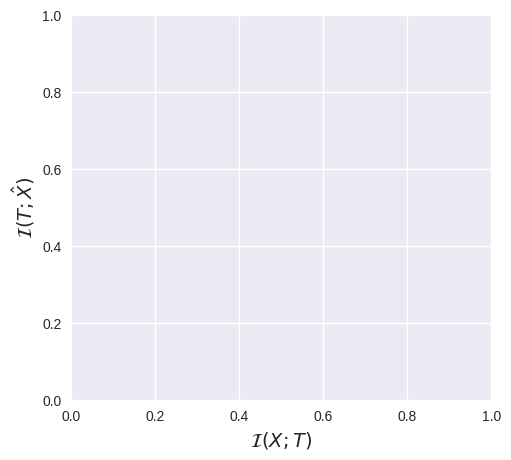

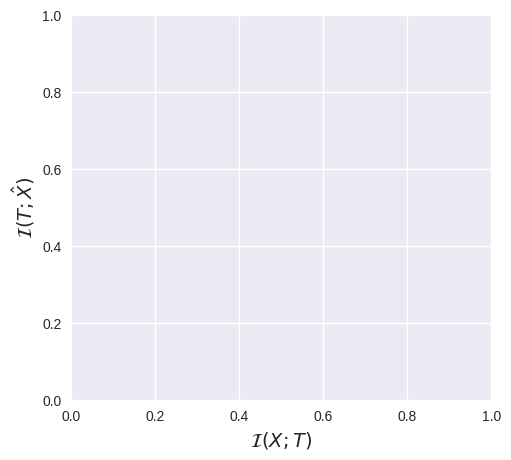

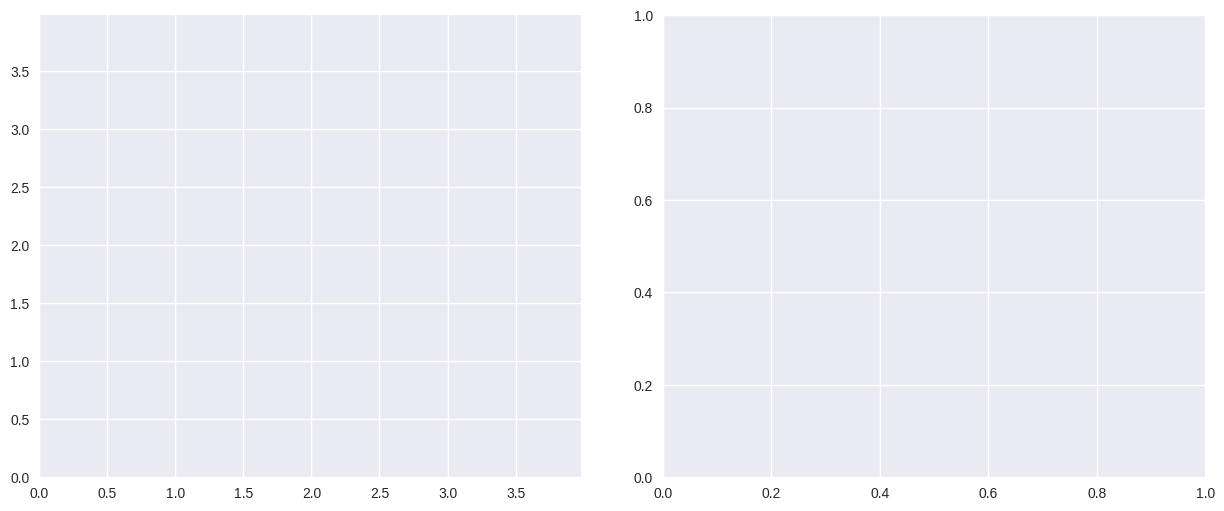

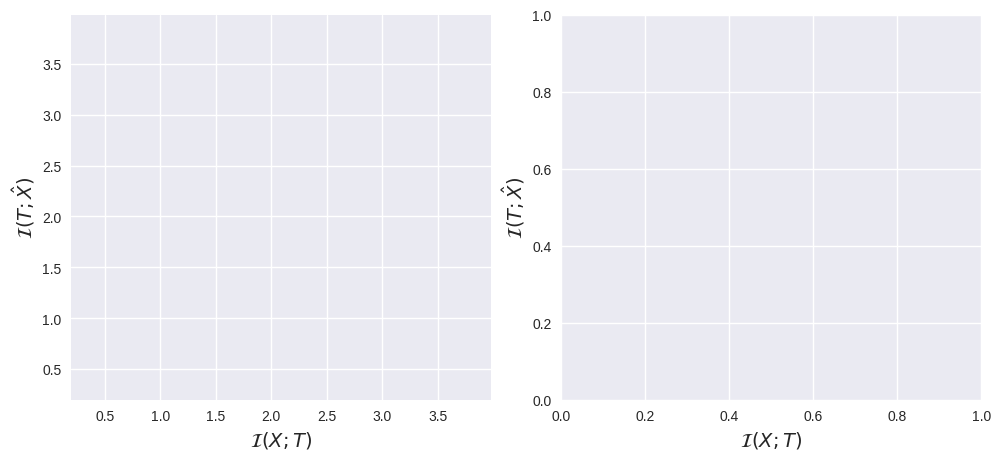

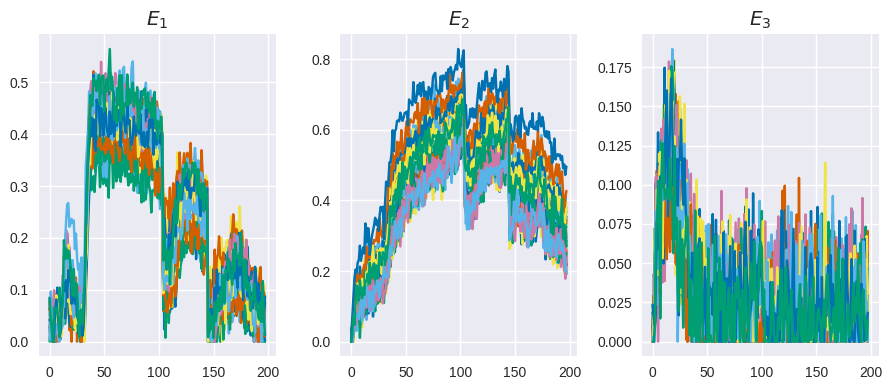

In [26]:
gt = torch.tensor(dataset.abundance()).permute(2,0,1)

#pick up the 32 first samples with the highest abundance per endmember
test_idx = torch.zeros(dataset.n_endmembers, 32, dtype=torch.long)
for i in range(dataset.n_endmembers):
    _, test_idx[i,:] = torch.topk(gt[i,:,:].flatten(), 32)

# sepparate train samples and test samples
train_idx = torch.ones_like(gt[0,:,:].flatten(), dtype=torch.bool)
train_idx[test_idx] = False
train_idx = torch.where(train_idx)[0]

# plot it
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(dataset[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

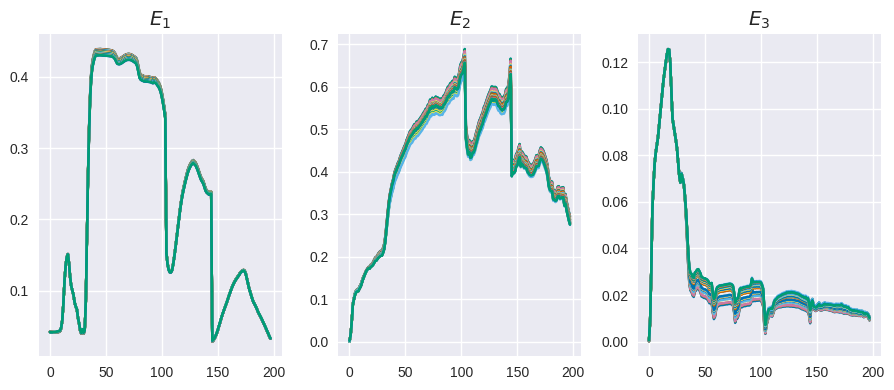

In [27]:
estimated_gt = dataset.A @ dataset.endmembers()

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(estimated_gt[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()



In [28]:
# create a subset of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx.flatten())
estimated_gt_test = estimated_gt[test_idx.flatten()]
# test_dataset = torch.utils.data.TensorDataset(estimated_gt_test)

In [29]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

test_Ax = define_Ax(estimated_gt_test, gamma=5e-2)
entropy_reference = renyis.entropy(test_Ax)
entropy_reference
# entropy_reference = estimated_gt_test

tensor(1.6589)

# CLHU Model

In [30]:
def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

In [31]:
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from HySpecLab.unmixing.mixture import lmm
from HySpecLab.unmixing.utils import slide

from IPDL import MatrixEstimator
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis


import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(encode_layers[-1], n_bands, bias=False),
            MatrixEstimator(.1)
        )
        
        # Abundance matrix
        self.A = None
        self.A_matrix_estimator = MatrixEstimator(.1)
        self.matrix_estimator = MatrixEstimator(.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.A_matrix_estimator(self.__similarity(r0))
        out = lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))
        return self.matrix_estimator(out)
        # return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features, affine=True),
            *[nn.ReLU(), nn.Dropout(.5)] if dropout else [nn.ReLU()],
            # *[nn.ReLU()] if dropout else [nn.Identity()],
            MatrixEstimator(.1)
        )

    def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        
        # return torch.log(torch.pow(cos, 2) + 1e-8)
        # return - torch.log(1 - torch.abs(cos) + 1e-8) # Buena
        cos_2 = (cos * 0.5) + 0.5
        return torch.log((cos_2)/(1 - cos_2 + 1e-8)) 
    
    
    def mi_ze(self, gamma=1e-1):
        '''
            Compute the mutual information between the latent space and the endmembers.
            I(Z;E) = H(Z) - H(Z|E)
        '''
        z_p = self.projection[-1].x.to(self.ebk.device)
        z = self.encoder[-1][-1].x.cpu()

        z_norm = nn.BatchNorm1d(len(z_p), affine=False, track_running_stats=False)
        z = z_norm(z_p)
        # z = self.encoder[-1][-1].x.cpu()
        Hz = renyis.entropy(define_Ax(z_p, gamma))
        # Hz = renyis.entropy(define_Ax(z_p, gamma))
        # Hz = renyis.entropy(self.encoder[-1][-2].get_matrix())
        
        a_norm = nn.BatchNorm1d(len(self.ebk), affine=False, track_running_stats=False)
        # A = a_norm(self.__similarity(z_p, temperature=1).detach()).cpu()
        # A = self.__similarity(z_p).detach().cpu()
        A = softmax(self.__similarity(z_p).detach().cpu(), dim=1)
        HA = renyis.entropy(define_Ax(A, gamma))

        # return HA - Hz
        return Hz - HA
    
    # def mi_ze(self, gamma=1e-2):
    #     '''
    #         Compute the mutual information between the latent space and the endmembers.
    #         I(Z;E) = H(Z) - H(Z|E)
    #     '''
    #     z_p = self.projection[-1].x.to(self.ebk.device)
    #     z = self.encoder[-1][-2].x.cpu()
    #     # z = self.encoder[-1][-1].x.cpu()
    #     Hz = renyis.entropy(define_Ax(z, gamma))
    #     # Hz = renyis.entropy(self.encoder[-1][-2].get_matrix())
        
    #     A = self.__similarity(z_p, temperature=1).detach().cpu()
    #     # A = softmax(self.__similarity(z_p).detach().cpu(), dim=1)
    #     HA = renyis.entropy(define_Ax(A, gamma))

    #     return Hz - HA


In [32]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPDL import ClassificationInformationPlane, AutoEncoderInformationPlane
from IPDL.optim import SilvermanOptimizer

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, train_dataset:Dataset, test_dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(train_dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))


    dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 0
    simplex_weight = 0
    # simplex_weight = 0
    similarity_weight = 1

    scaler = torch.cuda.amp.GradScaler()

    # gamma = 1e-2
    gamma = 5e-2
    #IPDL
    matrix_optimizer = SilvermanOptimizer(model, gamma=gamma, normalize_dim=True)
    ip = AutoEncoderInformationPlane(model)
    # ip = ClassificationInformationPlane(model, use_softmax=False)
    Ax = define_Ax(test_dataset[:], gamma=gamma)
    
    gt_abundance = test_dataset.dataset.A[test_dataset.indices]
    gt_endmember = test_dataset.dataset.E
    gt = gt_abundance @ gt_endmember
    Agt = define_Ax(gt, gamma=gamma)

    Ize = np.zeros(n_epochs+1)
    with torch.no_grad():
        model.eval()
        x = test_dataset[:].to(device)
        y = model(x)
        Ize[0] = model.mi_ze(gamma=1e-2)
        # Ize[0] = model.mi_ze(gamma=gamma)
        _, _ = ip.computeMutualInformation(Ax.to(device))

    # with torch.no_grad():
    #     model.eval()
    #     x = test_dataset[:].to(device)
    #     _ = model(x)
    #     # test_loss = criterion(y, x)
            
    #     _, _ = ip.computeMutualInformation(Ax.to(device))

    for epoch in epoch_iterator:
        epoch_loss = 0.
        model.train()
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            model.eval()
            x = test_dataset[:].to(device)
            y = model(x)
            test_loss = criterion(y, x)
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)), vls="%.4f" % test_loss.item())

        if epoch == 0: # Solo necesario una vez
            matrix_optimizer.step()

        _, _ = ip.computeMutualInformation(Ax.to(device))
        # _, _ = ip.computeMutualInformation(Ax.to(device), Agt.to(device))
        Ize[epoch+1] = model.mi_ze(gamma=1e-2)

    return ip, Ize

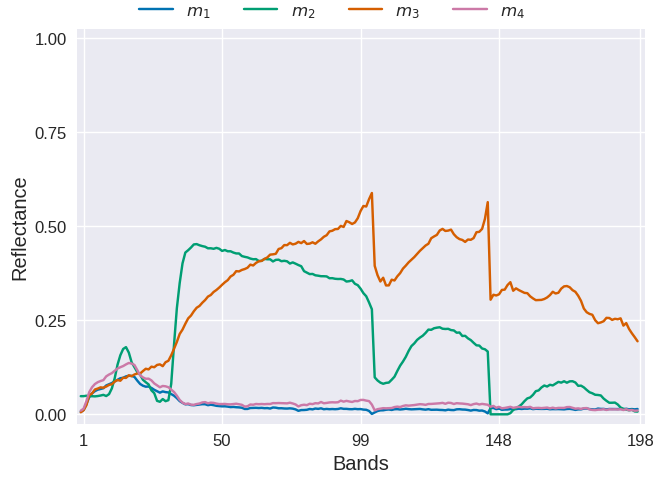

In [140]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers + 1
vca = VCA(n_endmembers=n_endmembers, snr_input=40, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    

fig = plot_endmembers(endmember_init)
plt.show()


In [141]:
# from utils import plot_endmembers
# from pysptools import eea
# n_endmembers = dataset.n_endmembers

# ee = eea.NFINDR()
# endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

# endmember_init = endmember.float()

# # endmember_init = endmember_init + (torch.randn_like(endmember_init) * .02)
# # endmember_init = torch.clip(endmember_init, 0, 1)

# # endmember_init[0] = endmember_init[1] + (torch.randn_like(endmember_init[1]) * .02)
# logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))
# # logit_endmember_init[0] = logit_endmember_init[2]

# # nfindr_endmember_init, _, _ = sort_endmember(endmember, dataset.endmembers())
# # nfindr_logit_endmember_init = torch.log((nfindr_endmember_init / (1-nfindr_endmember_init) + 1e-12))

# # apply soft noise to endmember
# # endmember_init = torch.abs(endmember_init + torch.randn_like(endmember_init) * .005)
# # logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))

# fig = plot_endmembers(endmember_init, ticks_range=(0, .95))
# plt.show(fig)

In [142]:
# model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=logit_endmember_init)
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, encode_layers=[128, 64, 32], endmember_init=logit_endmember_init)
ip, Ize = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=50, n_epochs=50, lr=1e-3)
# ip, Ize = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=25, n_epochs=100, lr=1e-3)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:24<00:00,  2.05epoch/s, tls=0.1595, vls=0.1793]


In [144]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

_X = test_dataset[:]

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.1793) tensor(0.5627) tensor(0.2680) tensor(0.0182)


In [146]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(0.0183), tensor(0.3542))

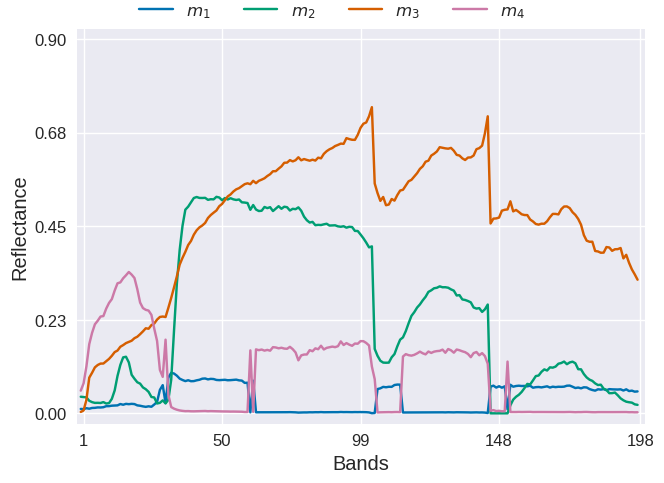

In [148]:
ebk = sigmoid(model.ebk.detach().cpu())
fig = plot_endmembers(ebk, ticks_range=(0, .9))
plt.show()

# fig.savefig(os.path.join(result_path, 'informationTheory/imgs/M_clhu_{}end.pdf'.format(n_endmembers)), bbox_inches='tight')


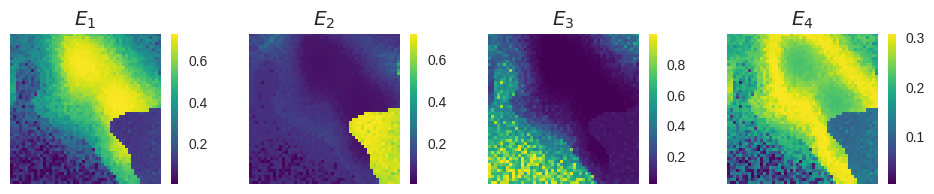

In [149]:
from torch.nn.functional import softmax
_ = model(dataset.X)

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# fig.savefig(os.path.join(result_path, 'informationTheory/imgs/A_clhu_{}end.pdf'.format(n_endmembers)), bbox_inches='tight')


# IP

In [150]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
def moving_average(a, n=10, padding_size=0) :
    ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.zeros(padding_size)), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def show_ip(ip_df: pd.DataFrame, n=25, labels=[], moving_average_n=25):
    '''
        Create a Information Plane illustration

        Parameters
        ----------
        ip_df : pd.Dataframe, dataframe which contains the MI. This dataframe
            has a specific structure which is created from IPDL.InformationPlane class
        n: int, Number of samples to visualize, sampling generated by a log-scale
    '''
    colors = ['Greys', 'Reds', 'Blues', 'Greens', 'Oranges',
                'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
                'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
                'BuGn', 'YlGn']

    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(6, 4),constrained_layout=False)
        gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.84, wspace=0.05)
        gs2 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=0.85, right=0.95, wspace=0)
        f8_ax1 = fig.add_subplot(gs1[:, :])
        f8_ax1.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
        f8_ax1.set_ylabel("$\mathcal{I}(T; Y)$", fontsize=14)

        for idx, (layer, _) in enumerate(ip_df.columns[::2]):
            Ity = moving_average(ip_df[layer]['Ity'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.3))
            Ixt = moving_average(ip_df[layer]['Ixt'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.3))
            
            cmap = cm[colors[idx]]
            iterations = np.geomspace(1, len(Ity)-1, num=n, dtype=np.uint)

            color = np.array([cmap(iterations[int(len(iterations)*0.95)])])
            sc = f8_ax1.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
            if not labels:
                f8_ax1.scatter([], [], c=color, label=layer)
            else:
                f8_ax1.scatter([], [], c=color, label=labels[idx])

            f8_ax2 = fig.add_subplot(gs2[0, idx])
            cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
            cb.set_ticks([])

        f8_ax1.legend()
        cb.set_ticks([0, iterations.max()])
        f8_ax2.set_yticklabels(['0', ip_df[layer]['Ixt'].size - 1])
        cb.set_label("Iterations", labelpad=-18)

    return fig

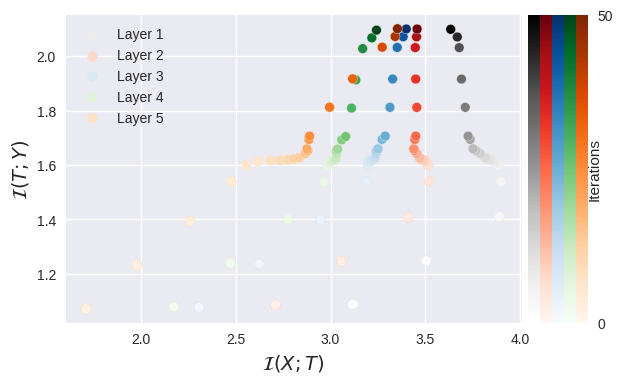

In [152]:
df = ip.to_df()

fig = show_ip(df, n=30, moving_average_n=10)
plt.show(fig)

(5, 51)
(5, 51)


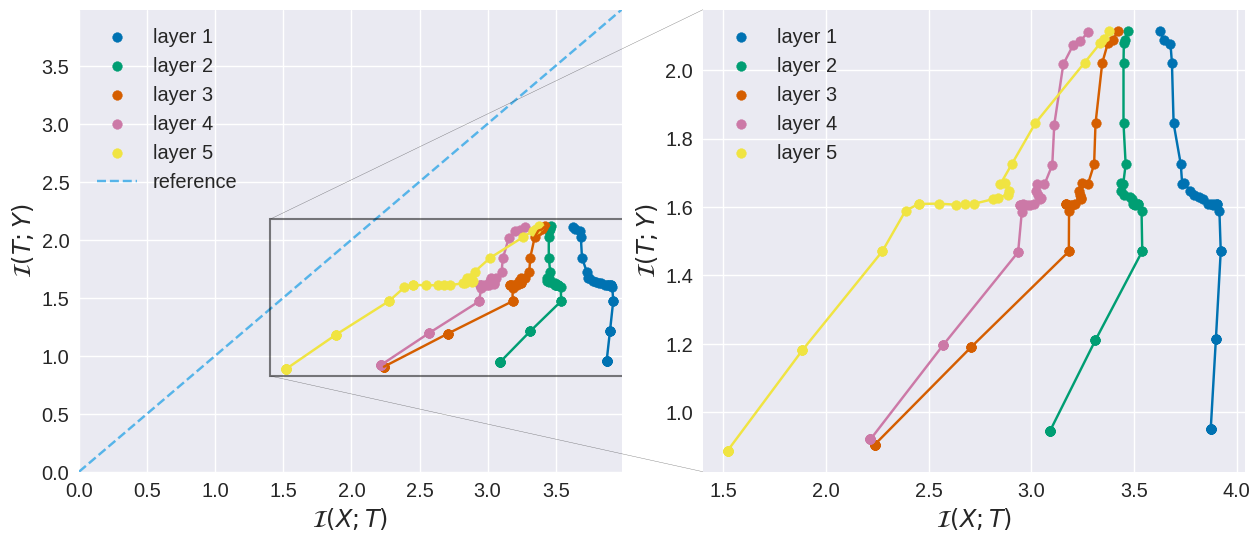

In [154]:
from IPDL import MatrixBasedRenyisEntropy

def moving_average_2(a:np.ndarray, n=3, padding_size=2):
    ''' 
        Moving average filter for 1-D array.
        Parameters
        ----------
        a : 1-D array, shape (batch_size, n_features)
            Input array.
        n : int, optional
            Window size. Default is 3.
        padding_size : int, optional
            Padding size. Default is 2.
    
    '''
    if padding_size > 0:
        a = np.pad(a, ((0,0), (padding_size//2, padding_size//2)), 'edge')

    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

Ax = define_Ax(test_dataset[:], gamma=5e-2)
# Ax = define_Ax(test_dataset[:][0], gamma=1e-3)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
    ax.set(xlim=(0, reference), ylim=(0, reference))
    axins = ax.inset_axes([1.15, 0., 1, 1])

    Ixt, Ity = ip.getMutualInformation(moving_average_n=1)
    print(np.array(Ixt).shape)
    Ixt = moving_average_2(np.array(Ixt), n=5, padding_size=4)
    Ity = moving_average_2(np.array(Ity), n=5, padding_size=4)
    print(Ixt.shape)

    iterations = np.geomspace(1, len(Ixt[0])-1, 30, dtype=np.uint)
    for idx, current_Ixt in enumerate(Ixt[:]):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt[iterations], current_Ity[iterations], label="layer {}".format(idx+1))
        ax.plot(current_Ixt[iterations], current_Ity[iterations])

        axins.scatter(current_Ixt[iterations], current_Ity[iterations], label="layer {}".format(idx+1))
        axins.plot(current_Ixt[iterations], current_Ity[iterations])

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')

axins.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
axins.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
axins.legend(fontsize='x-large')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', label='reference')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

In [155]:
reference

tensor(3.9830)

In [156]:
df = ip.to_df()
df.to_csv(os.path.join(result_path, 'informationTheory/ip_{}end.csv'.format(n_endmembers)), index=False)
df.to_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))

In [46]:
os.path.join(result_path, 'informationTheory/ip_{}end.csv'.format(n_endmembers))

'/media/abian/Extreme SSD/Thesis/CLHU/results/syntheticData/informationTheory/ip_5end.csv'

In [47]:
# Ize to dataframe
df = pd.DataFrame(Ize, columns=['Ize'])
# df.to_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers)), index=False)

In [1577]:
Ize

array([0.11061704, 2.86038399, 3.3194561 , 3.32356286, 2.96464062,
       2.91366291, 2.45459771, 2.21959567, 2.50999403, 2.0544765 ,
       1.94176626, 2.13094854, 2.24738693, 1.75820684, 1.87560272,
       1.88834953, 1.9455862 , 1.96786904, 1.8289156 , 1.87678528,
       1.92225838, 1.77676439, 1.68423748, 1.72369814, 1.82259941,
       2.06624508, 1.89867854, 1.57169199, 1.73342514, 1.7157259 ,
       1.6989398 , 1.65436983, 1.91832972, 1.79617119, 1.66493607,
       1.62595367, 1.65732098, 1.74322271, 1.72718048, 1.78076315,
       1.76505613, 1.69344997, 1.7123394 , 1.7533412 , 1.74972105,
       1.86601114, 1.75098133, 1.85086298, 1.87566137, 1.98879623,
       1.94392371])

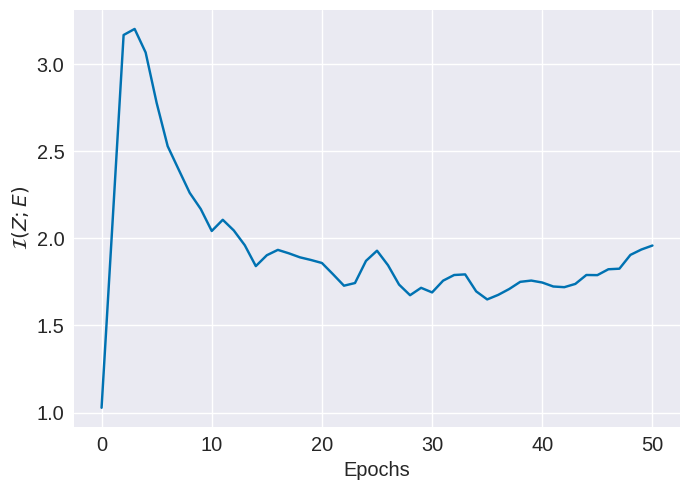

In [1578]:
from utils import moving_average

Ize_average = moving_average(Ize.reshape(1,-1), n=3, padding_size=2) 
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(Ize_average.T)
    plt.xlabel('Epochs', fontsize='x-large')
    plt.ylabel('$\mathcal{I}(Z;E)$', fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

In [1579]:
from IPDL import MatrixBasedRenyisEntropy as renyis
estimated_gt_test = estimated_gt[test_idx.flatten()]
Agt = define_Ax(estimated_gt_test[:], gamma=1e-1)
renyis.entropy(Agt)

tensor(1.6062)

In [1580]:
reconstruct = model(test_dataset[:])
A = define_Ax(reconstruct.detach().cpu(), gamma=1e-1)
renyis.entropy(A)

tensor(1.7860)

# Images

In [15]:
# def moving_average(a:np.ndarray, n=3, padding_size=2):
#     ''' 
#         Moving average filter for 1-D array.
#         Parameters
#         ----------
#         a : 1-D array, shape (batch_size, n_features)
#             Input array.
#         n : int, optional
#             Window size. Default is 3.
#         padding_size : int, optional
#             Padding size. Default is 2.
    
#     '''
#     if padding_size > 0:
#         a = np.pad(a, ((0,0), (padding_size//2, padding_size//2)), 'edge')

#     ret = np.cumsum(a, axis=1, dtype=float)
#     ret[:, n:] = ret[:, n:] - ret[:, :-n]
#     return ret[:, n - 1:] / n

def moving_average(a, n=3, padding_size=2) :
    # ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.zeros(padding_size)), dtype=float)
    ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.ones(padding_size)*a[0]), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

## 3 endmembers

In [122]:
import pandas as pd
n_endmembers = 3
ip_df = pd.read_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))
# ip_df = ip.to_df()

ip_df

Layer 1             Layer 2             Layer 3             Layer 4  \
         Ixt       Ity       Ixt       Ity       Ixt       Ity       Ixt   
0   3.739022  0.109435  2.394821  0.104244  0.917946  0.075525  1.323062   
1   3.932125  1.514892  3.593521  1.514486  3.181896  1.512648  2.887774   
2   3.951552  1.579408  3.590552  1.579389  3.054078  1.579016  2.788218   
3   3.928093  1.588291  3.528123  1.588275  3.070153  1.588092  2.784590   
4   3.902408  1.597843  3.536177  1.597814  3.144604  1.597664  2.875291   
5   3.909529  1.620071  3.570782  1.619997  3.225176  1.619921  2.946609   
6   3.905118  1.644351  3.534467  1.644187  3.245439  1.644045  2.971833   
7   3.885736  1.688200  3.498808  1.688107  3.184838  1.687973  2.908536   
8   3.896412  1.642912  3.525182  1.642766  3.212134  1.642613  2.941709   
9   3.823154  1.713161  3.467468  1.713128  3.204954  1.713051  2.948734   
10  3.825509  1.788440  3.472134  1.788428  3.220767  1.788537  2.970085   
11  3.808344  1.783445  3.472219  1.783545  3.228145  1.783730  2.976104   
12  3.846121  1.704523  3.496107  1.704417  3.250335  1.704271  3.005688   
13  3.779897  1.824839  3.453954  1.825241  3.209280  1.825226  2.975032   
14  3.796395  1.824751  3.462525  1.824991  3.225531  1.825266  3.002717   
15  3.770166  1.762499  3.426528  1.762500  3.202791  1.762465  2.984684   
16  3.800889  1.843124  3.484309  1.843262  3.255779  1.843528  3.031925   
17  3.854259  1.747707  3.553366  1.747569  3.352401  1.747456  3.150585   
18  3.832075  1.862011  3.513968  1.862024  3.310843  1.862125  3.104608   
19  3.814532  1.882792  3.494557  1.882854  3.326214  1.883201  3.127761   
20  3.847704  1.810511  3.534315  1.810464  3.362451  1.810515  3.184888   
21  3.838172  1.834026  3.525494  1.833957  3.335744  1.833883  3.150794   
22  3.793373  1.887193  3.469432  1.887324  3.298417  1.887331  3.097863   
23  3.813626  1.918921  3.506764  1.919089  3.305380  1.919198  3.116842   
24  3.744116  1.931337  3.469952  1.931637  3.313922  1.931922  3.122335   
25  3.770068  1.864852  3.464180  1.865025  3.312066  1.865211  3.126270   
26  3.775578  1.931201  3.472613  1.931562  3.326816  1.931809  3.142241   
27  3.768679  2.001185  3.450381  2.001025  3.298331  2.001091  3.108665   
28  3.751496  1.908388  3.470183  1.908519  3.316025  1.908537  3.141193   
29  3.748013  1.923823  3.465753  1.924089  3.312456  1.924192  3.135446   
30  3.715284  1.961090  3.436902  1.961314  3.293078  1.961279  3.119262   
31  3.738302  1.924474  3.467838  1.924797  3.324263  1.924693  3.159863   
32  3.748194  1.930915  3.489202  1.931294  3.338795  1.931434  3.174520   
33  3.717131  1.967533  3.482065  1.967835  3.363278  1.968051  3.196596   
34  3.732806  2.005908  3.489046  2.006068  3.363769  2.006197  3.198630   
35  3.747273  2.048972  3.466755  2.048872  3.349937  2.048829  3.183260   
36  3.734715  1.989051  3.489657  1.989576  3.373042  1.989557  3.221210   
37  3.704412  1.971456  3.458504  1.972014  3.354923  1.972104  3.206506   
38  3.703638  1.982030  3.463261  1.982493  3.344390  1.982501  3.193428   
39  3.693015  1.983121  3.464963  1.983484  3.356753  1.983396  3.201661   
40  3.686424  1.993679  3.440929  1.994057  3.308552  1.993673  3.156247   
41  3.687005  1.997149  3.445621  1.997582  3.317192  1.997231  3.166095   
42  3.697337  2.038826  3.456699  2.039345  3.327135  2.039108  3.173203   
43  3.714004  2.006626  3.476664  2.007237  3.363994  2.007217  3.214734   
44  3.666429  2.008108  3.452736  2.008748  3.330331  2.008556  3.180277   
45  3.693818  2.018850  3.475406  2.019893  3.352225  2.019992  3.194727   
46  3.697979  2.042342  3.478698  2.043427  3.369231  2.043421  3.213995   
47  3.687606  2.032939  3.473119  2.033809  3.350647  2.033736  3.193437   
48  3.675132  2.032279  3.489104  2.033249  3.371843  2.033110  3.215111   
49  3.691876  2.061915  3.487298  2.062963  3.387258  2.062975  3.239288   
50  3.664865  2.024487  3.464711  2.025293  3.372444 

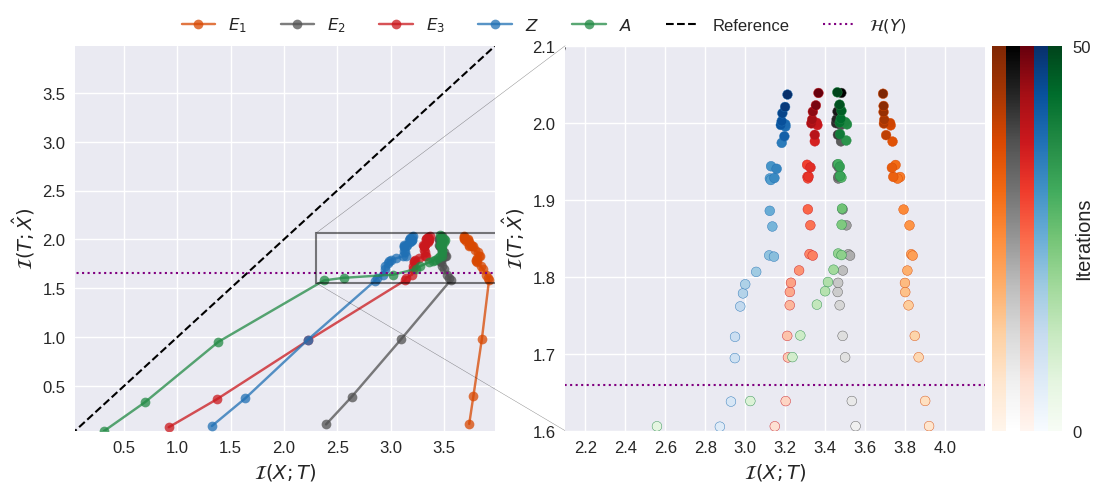

In [135]:
import matplotlib
n_layers = ip_df.columns[::2].size
n_epochs = len(ip_df) - 1
n_iterations = 30
labels = ['$E_1$', '$E_2$', '$E_3$', '$Z$', "$A$"]
iterations = np.linspace(0, n_epochs-1, n_iterations, dtype=np.uint)


colors = [  'Oranges', 'Greys', 'Reds', 'Blues', 'Greens',
            'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
            'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
            'BuGn', 'YlGn'  ]

fig = plt.figure(figsize=(7, 5),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.68, wspace=0.05)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.78, right=1.38, wspace=0)
gs3 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=1.39, right=1.49, wspace=0)

ax = fig.add_subplot(gs1[:, :])
ax.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
ax.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)
ax.set(xlim=(reference-(reference*.99), reference), ylim=(reference-(reference*.99), reference))

axins = fig.add_subplot(gs2[:, :])
axins.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
axins.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)

for i in range(n_layers):
    Ixt = ip_df[ip_df.columns[2*i]].to_numpy()#.reshape(1, -1)
    Ity = ip_df[ip_df.columns[2*i + 1]].to_numpy()#.reshape(1, -1)

    Ixt = moving_average(Ixt, n=5, padding_size=4).reshape(-1)
    Ity = moving_average(Ity, n=5, padding_size=4).reshape(-1)

    cmap = cm[colors[i]]

    # obtaain color with the largest constrast
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n_iterations)
    color = cmap(0.75)
    # ax.scatter(Ixt[iterations], Ity[iterations], color=color, alpha=.75)
    ax.plot(Ixt[iterations], Ity[iterations], '-o', color=color, alpha=.75, label=labels[i])

    sc = axins.scatter(Ixt[iterations[3:]], Ity[iterations[3:]], c=iterations[3:], vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
    # axins.plot(Ixt[iterations[4:]], Ity[iterations[4:]], color=color, alpha=.75, label=labels[i])

    f8_ax2 = fig.add_subplot(gs3[0, i])
    cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
    cb.set_ticks([])

# entropy_reference = 1.9
ax.plot([0, reference], [0, reference], color='black', linestyle='--', linewidth=1.5, label='Reference')
ax.plot([0, reference], [entropy_reference, entropy_reference], color='purple', linestyle=':', linewidth=1.5, label='$\mathcal{H}(Y)$')
ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)

# plot a line with the entropy of the reference without changes the ticks in x
_x_ticks = axins.get_xticks()
_y_ticks = axins.get_yticks()
axins.plot([0, reference], [0, reference], color='black', linestyle='--', linewidth=1.5, label='Reference')
axins.plot([0, reference + 2], [entropy_reference, entropy_reference], color='purple', linestyle=':', linewidth=1.5, label='$\mathcal{H}(Y)$')
axins.set_xticks(_x_ticks[0:-1])
axins.set_xlim(_x_ticks[0] - 1e-1, _x_ticks[-1])
axins.set_yticks(_y_ticks[:])
axins.set_ylim(_y_ticks[1], _y_ticks[-1])




# handles, labels = axins.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=10, fontsize='large', bbox_to_anchor=(.75, 0.97))

ax.tick_params(axis='both', which='major', labelsize='large')
axins.tick_params(axis='both', which='major', labelsize='large')
cb.set_ticks([0, iterations.max()])
f8_ax2.set_yticklabels(['0', n_epochs], fontsize='large')
cb.set_label("Iterations", labelpad=-12, fontsize='x-large')

plt.show()

fig.savefig('ip_end3.pdf', bbox_inches='tight')

## 5 endmembers

In [137]:
import pandas as pd
n_endmembers = 5
ip_df = pd.read_pickle(os.path.join(result_path, 'informationTheory/ip_{}end.pkl'.format(n_endmembers)))

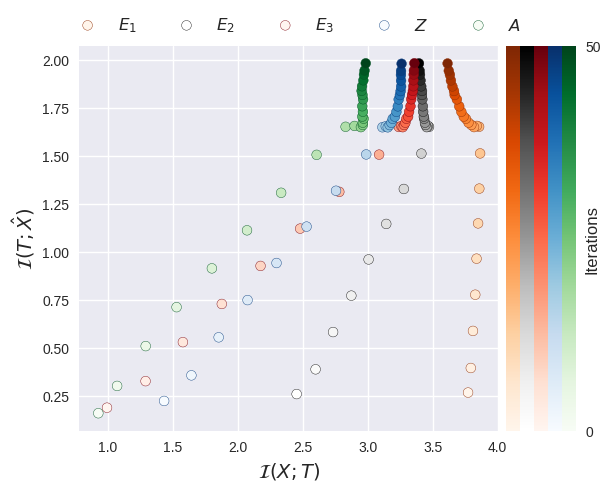

In [138]:
n_layers = ip_df.columns[::2].size
n_epochs = len(ip_df) - 1
n_iterations = 25
labels = ['$E_1$', '$E_2$', '$E_3$', '$Z$', "$A$"]
iterations = np.linspace(0, n_epochs-1, n_iterations, dtype=np.uint)


colors = [  'Oranges', 'Greys', 'Reds', 'Blues', 'Greens',
            'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
            'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
            'BuGn', 'YlGn'  ]

fig = plt.figure(figsize=(7, 5),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.68, wspace=0.05)
gs2 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=.69, right=.79, wspace=0)
# gs3 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=1.39, right=1.49, wspace=0)

ax = fig.add_subplot(gs1[:, :])
ax.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
ax.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)
# ax.set(xlim=(reference-(reference*.45), reference), ylim=(reference-(reference*.45), reference))

for i in range(n_layers):
    Ixt = ip_df[ip_df.columns[2*i]].to_numpy()#.reshape(1, -1)
    Ity = ip_df[ip_df.columns[2*i + 1]].to_numpy()#.reshape(1, -1)

    Ixt = moving_average(Ixt, n=15, padding_size=14).reshape(-1)
    Ity = moving_average(Ity, n=15, padding_size=14).reshape(-1)

    cmap = cm[colors[i]]

    # obtaain color with the largest constrast
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n_iterations)
    color = cmap(norm(n_iterations*.95))
    sc = ax.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color, label = labels[i])
    # ax.plot(Ixt[iterations], Ity[iterations], '-o', color=color, alpha=.75, label = labels[i])

    f8_ax2 = fig.add_subplot(gs2[0, i])
    cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
    cb.set_ticks([])


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=10, fontsize='large', bbox_to_anchor=(.39, 0.97))

cb.set_ticks([0, iterations.max()])
f8_ax2.set_yticklabels(['0', n_epochs])
cb.set_label("Iterations", labelpad=-12, fontsize='large')

plt.show()

fig.savefig('ip_end4.pdf', bbox_inches='tight')

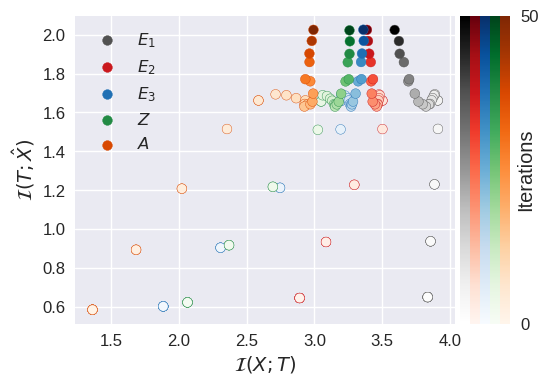

In [139]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
def moving_average(a, n=10, padding_size=0) :
    # ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.zeros(padding_size)), dtype=float)
    ret = np.cumsum(a, dtype=float) if padding_size == 0 else np.cumsum(np.insert(a, 0, np.ones(padding_size)*a[0]), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def show_ip(ip_df: pd.DataFrame, n=25, labels=[], moving_average_n=25):
    '''
        Create a Information Plane illustration

        Parameters
        ----------
        ip_df : pd.Dataframe, dataframe which contains the MI. This dataframe
            has a specific structure which is created from IPDL.InformationPlane class
        n: int, Number of samples to visualize, sampling generated by a log-scale
    '''
    colors = ['Greys', 'Reds', 'Blues', 'Greens', 'Oranges',
                'Purples', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd',
                'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn',
                'BuGn', 'YlGn']

    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(5, 4),constrained_layout=False)
        gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.84, wspace=0.05)
        gs2 = fig.add_gridspec(nrows=1, ncols=len(ip_df.keys()[::2]), left=0.85, right=0.95, wspace=0)
        f8_ax1 = fig.add_subplot(gs1[:, :])
        f8_ax1.set_xlabel("$\mathcal{I}(X; T)$", fontsize=14)
        f8_ax1.set_ylabel("$\mathcal{I}(T; \hat{X})$", fontsize=14)

        for idx, (layer, _) in enumerate(ip_df.columns[::2]):
            Ity = moving_average(ip_df[layer]['Ity'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.75))
            Ixt = moving_average(ip_df[layer]['Ixt'].to_numpy(), n=moving_average_n, padding_size=int(moving_average_n*0.75))
            
            cmap = cm[colors[idx]]
            iterations = np.geomspace(1, len(Ity)-1, num=n, dtype=np.uint)

            color = np.array([cmap(0.75)])
            sc = f8_ax1.scatter(Ixt[iterations], Ity[iterations], c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
            if not labels:
                f8_ax1.scatter([], [], c=color, label=layer)
            else:
                f8_ax1.scatter([], [], c=color, label=labels[idx])

            f8_ax2 = fig.add_subplot(gs2[0, idx])
            cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
            cb.set_ticks([])


        f8_ax1.tick_params(axis='both', which='major', labelsize='large')
        f8_ax1.legend(fontsize='large')
        cb.set_ticks([0, iterations.max()])
        f8_ax2.set_yticklabels(['0', ip_df[layer]['Ixt'].size - 1], fontsize='large')
        cb.set_label("Iterations", labelpad=-16, fontsize='x-large')

    return fig

fig = show_ip(ip_df, n=30, labels=labels, moving_average_n=5)
plt.show(fig)
fig.savefig('ip_end4.pdf', bbox_inches='tight')

## $\mathcal{I}(Z;M)$

In [100]:
import pandas as pd
n_endmembers = 3
Ize_3end_df = pd.read_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers)))
Ize_4end_df = pd.read_csv(os.path.join(result_path, 'informationTheory/Ize_{}end.csv'.format(n_endmembers+1)))

In [101]:
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5), constrained_layout=False)
    Ize_3end = Ize_3end_df['Ize'].to_numpy().reshape(1, -1)
    Ize_3end = moving_average(Ize_3end, n=5, padding_size=4).reshape(-1)
    Ize_4end = Ize_4end_df['Ize'].to_numpy().reshape(1, -1)
    Ize_4end = moving_average(Ize_4end, n=5, padding_size=4).reshape(-1)
    plt.plot(Ize_3end, label='3 endmembers')
    plt.plot(Ize_4end, label='4 endmembers')
    plt.xlabel('Iterations', fontsize='x-large')
    plt.ylabel('$\mathcal{I}(Z; M)$', fontsize='x-large')

plt.legend(fontsize='x-large')
# ticks to 'x-large'
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()

fig.savefig('Izm.pdf', bbox_inches='tight')

ValueError: operands could not be broadcast together with shapes (4,) (51,) 

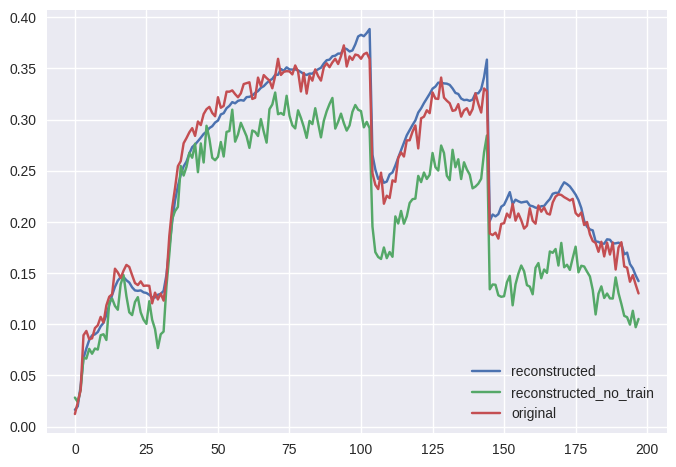

In [125]:
model2 = ContrastiveUnmixing(dataset.n_bands, n_endmembers, encode_layers=[512, 32], endmember_init=logit_endmember_init)

y = model(dataset.X)
y_2 = model2(dataset.X)
from matplotlib import pyplot as plt 

sample = 0
plt.plot(y[sample].detach().numpy(), label='reconstructed')
plt.plot(y_2[sample].detach().numpy(), label='reconstructed_no_train')
plt.plot(dataset.X[sample].numpy(), label='original')
plt.legend()
plt.show()





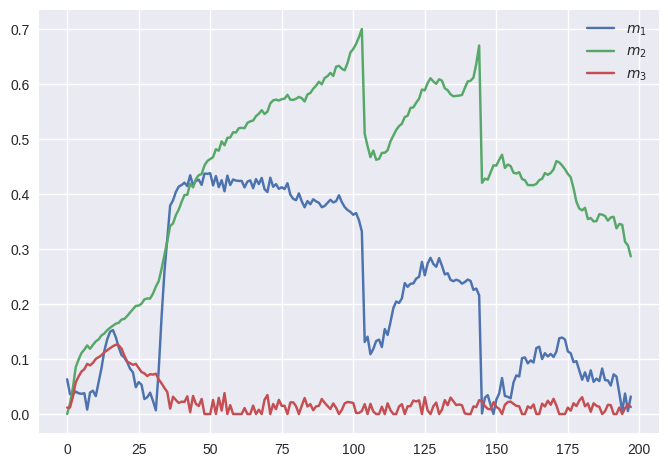

In [126]:
M = sigmoid(model.ebk)
plt.plot(M.detach().numpy().T, label=["$m_1$", "$m_2$", "$m_3$"])
plt.legend()
plt.show()

In [128]:
softmax(model.A[sample].detach()), softmax(model2.A[sample].detach())

/tmp/ipykernel_7732/3814850959.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(model.A[sample].detach()), softmax(model2.A[sample].detach())


(tensor([0.1972, 0.4589, 0.3439]), tensor([0.3148, 0.2884, 0.3968]))

In [130]:
sad(dataset.X[sample].reshape(1, -1), M).detach(), sad(y[sample].reshape(1, -1), M).detach()

(tensor([0.3512, 0.1378, 1.0892]), tensor([0.3800, 0.0993, 1.1012]))